In [1]:

import sys
sys.path.append("..")

import deeptrack as dt
#import graphtrack as gt
from deeptrack.models.gnns.generators import GraphGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logging


logging.disable(logging.WARNING)


c:\Users\santh\Desktop\Python Projects\Masters Thesis\Multi_particleTracking\GraphTrack\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\Users\santh\Desktop\Python Projects\Masters Thesis\Multi_particleTracking\GraphTrack\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


In [2]:
import os
import glob

import re

import tqdm
import untangle
from graphtrack import graphs

_default_properties = {"intensity": 255.0} # "radius": 3
def NodeExtractor(
    paths=None,
    properties: dict = _default_properties,
    extract_solution=False,
    **kwargs,
):
    def to_frame(xml):
        particles = xml.root.GlobalHeterogenousInfo.particle

        detection_list = []
        for p in range(len(particles)):
            detections = particles[p].detection
            for d in range(len(detections)):
                detection_att = {
                    "frame": int(detections[d]["frame"]),
                    "centroid_x": float(detections[d]["x"]),
                    "centroid_y": float(detections[d]["y"]),
                    "intensity": float(detections[d]["intensity"]),
                    #"radius": float(detections[d]["radius"]),
                    "label": int(p + 1),
                }
                if extract_solution:
                    detection_att["solution"] = float(
                        detections[d]["solution"]
                    )

                detection_list.append(detection_att)
        df = (
            pd.DataFrame.from_dict(detection_list)
            .sort_values(by=["frame"])
            .reset_index(drop=True)
        )
        df["solution"] = 0.0
        return df, np.array([0.0])

    _properties = {
        "label": 1,
        "centroid": np.array([150.0, 150.0]).astype(np.float32),
    }
    _properties.update(properties)

    dfs, global_property = [], []
    for batch, path in tqdm.tqdm(
        enumerate(paths), total=len(paths), desc="Loading xmls"
    ):
        df, global_prop = to_frame(untangle.parse(path))

        # Normalize features
        """df.loc[:, df.columns.str.contains("centroid")] = np.round(
            df.loc[:, df.columns.str.contains("centroid")]
            / _properties["centroid"],
            3,
        )"""
        df["intensity"] = np.round(
            df["intensity"] / _properties["intensity"], 3
        )
        #df["radius"] = np.round(df["radius"] / _properties["radius"], 3)

        # Append solution
        if not ("solution" in df.columns):
            df["solution"] = 0.0

        # Append set
        df["set"] = batch
        dfs.append(df)
        global_property.append(global_prop)

    dfs = pd.concat(dfs)
    # dfs = dfs.clip(lower=0)

    return dfs, list(_properties.keys()), global_property


_path_to_xml = os.path.join(
    ".", "xml-generators", "xml_data", "{_type}", "{mode}", "*.xml"
)


def LoadGraphXml(_type="mixed_alpha", mode="training", **kwargs):
    PATH_TO_DATASET = glob.glob(_path_to_xml.format(_type=_type, mode=mode))
    nodesdf, props, global_property = NodeExtractor(PATH_TO_DATASET, **kwargs)

   
    return nodesdf

c:\Users\santh\Desktop\Python Projects\Masters Thesis\Multi_particleTracking\GraphTrack\graphtrack\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\Users\santh\Desktop\Python Projects\Masters Thesis\Multi_particleTracking\GraphTrack\graphtrack\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


# New Section

In [8]:
nodesdf = LoadGraphXml(_type="mixed_alpha_nodes", mode="training")

Loading xmls: 100%|██████████| 50/50 [00:01<00:00, 41.85it/s]


In [9]:
nodesdf["centroid_y"].max() 

129.55402482311692

In [10]:
nodesdf["centroid_x"] = np.round(nodesdf["centroid_x"] / 530.0 , 3)#nodesdf["centroid_x"].max() , 3)
nodesdf["centroid_y"] = np.round(nodesdf["centroid_y"] / 100.0 , 3)# nodesdf["centroid_y"].max() , 3)

In [11]:
nodesdf.head()

,frame,centroid_x,centroid_y,intensity,label,solution,set
0,0,0.784,0.537,0.528,1,0.0,0
1,0,0.631,0.412,0.554,26,0.0,0
2,0,0.532,0.548,0.533,4,0.0,0
3,0,0.162,0.301,0.550,27,0.0,0
4,0,0.346,0.489,0.538,28,0.0,0


In [160]:
# Seach radius for the graph edges
radius = 0.20

# Output type
_OUTPUT_TYPE = "edges"

variables = dt.DummyFeature(
    radius=radius,
    output_type=_OUTPUT_TYPE,
    nofframes=3
)

In [173]:
model = dt.models.gnns.MAGIK(
    dense_layer_dimensions=(32, 64, 96),      # number of features in each dense encoder layer
    base_layer_dimensions=(96, 96),    # Latent dimension throughout the message passing layers
    number_of_node_features=3,             # Number of node features in the graphs
    number_of_edge_features=1,             # Number of edge features in the graphs
    number_of_edge_outputs=1,              # Number of predicted features
    edge_output_activation="sigmoid",      # Activation function for the output layer
    output_type=_OUTPUT_TYPE,              # Output type. Either "edges", "nodes", or "graph"
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics=['accuracy'],
)

model.summary()

C:\Users\santh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\activations\gelu.py:79: UserWarning: Default value of `approximate` is changed from `True` to `False`
  warnings.warn(


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
node_ide1 (Dense)               (None, None, 32)     128         input_21[0][0]                   
__________________________________________________________________________________________________
lambda (Lambda)                 multiple             0           node_ide1[0][0]                  
                                                                 edge_ide1[0][0]                  
                                                                 node_ide2[0][0]                  
                                                                 edge_ide2[0][0]            

In [14]:

generator = GraphGenerator(
        nodesdf=nodesdf,
        properties=["centroid"],# , "radius", "intensity"
        #parenthood=parenthood,
        min_data_size=360,
        max_data_size=361,
        batch_size=8,
        **variables.properties()
    )
    
    

Creating graph edges...


 32%|███▏      | 16/50 [00:40<01:23,  2.46s/it]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/content/deeptrack/models/gnns/graphs.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["key"] = 1
100%|██████████| 50/50 [01:59<00:00,  2.39s/it]


In [15]:
with generator:
    model.fit(generator, epochs=50)

Generating 361 / 360 samples before starting training
Epoch 1/50


/content/deeptrack/image.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(self.to_numpy()._value)


45/45 [==============================] - 19s 54ms/step - loss: 0.2046 - accuracy: 0.9130
Epoch 2/50
45/45 [==============================] - 3s 61ms/step - loss: 0.0837 - accuracy: 0.9678
Epoch 3/50
45/45 [==============================] - 3s 58ms/step - loss: 0.0760 - accuracy: 0.9699
Epoch 4/50
45/45 [==============================] - 3s 57ms/step - loss: 0.0716 - accuracy: 0.9711
Epoch 5/50
45/45 [==============================] - 2s 35ms/step - loss: 0.0687 - accuracy: 0.9723
Epoch 6/50
45/45 [==============================] - 2s 54ms/step - loss: 0.0694 - accuracy: 0.9718
Epoch 7/50
45/45 [==============================] - 3s 59ms/step - loss: 0.0687 - accuracy: 0.9720
Epoch 8/50
45/45 [==============================] - 3s 55ms/step - loss: 0.0681 - accuracy: 0.9721
Epoch 9/50
45/45 [==============================] - 3s 59ms/step - loss: 0.0680 - accuracy: 0.9718
Epoch 10/50
45/45 [==============================] - 3s 60ms/step - loss: 0.0673 - accuracy: 0.9720
Epoch 11/50
45/45 [

In [17]:
model.save("./gnn1")

In [174]:
model.load_weights("./gnn_rad1_intens")

## Testing with the test data

In [6]:
test_nodesdf = LoadGraphXml(_type="mixed_alpha_nodes", mode="testing")



Loading xmls: 100%|██████████| 5/5 [00:00<00:00, 21.59it/s]


In [7]:
uniqueValues_set = test_nodesdf['set'].unique()
uniqueValues_set

array([0, 1, 2, 3, 4], dtype=int64)

In [8]:
test_nodesdf_set = test_nodesdf[test_nodesdf["set"] ==  2]

In [9]:
test_nodesdf_set["centroid_x"] = np.round(test_nodesdf_set["centroid_x"] / 212, 3)
test_nodesdf_set["centroid_y"] = np.round(test_nodesdf_set["centroid_y"] / 40, 3)

C:\Users\santh\AppData\Local\Temp\ipykernel_13564\402880870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_nodesdf_set["centroid_x"] = np.round(test_nodesdf_set["centroid_x"] / 212, 3)
C:\Users\santh\AppData\Local\Temp\ipykernel_13564\402880870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_nodesdf_set["centroid_y"] = np.round(test_nodesdf_set["centroid_y"] / 40, 3)


In [11]:
test_nodesdf_set.head()

,frame,centroid_x,centroid_y,intensity,label,solution,set
0,0,0.337,2.183,0.299,1,0.0,2
1,0,0.333,2.319,0.267,23,0.0,2
2,0,0.308,0.338,0.334,24,0.0,2
3,0,0.306,2.045,0.330,25,0.0,2
4,0,0.161,0.540,0.354,26,0.0,2


In [13]:
pred, gt, scores, graph = dt.models.gnns.get_predictions(
    test_nodesdf_set, [ "centroid"], model, variables
)#"intensity",

Creating graph edges...


100%|██████████| 1/1 [00:03<00:00,  3.04s/it]
C:\Users\santh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\activations\gelu.py:79: UserWarning: Default value of `approximate` is changed from `True` to `False`
  warnings.warn(


In [14]:
edges_df, nodes, _ = dt.models.gnns.df_from_results(pred, gt, scores, graph)



In [15]:
# display the first 10 rows of the dataframe
edges_df.head(1000)

,frame_x,frame_y,node_x,node_y,gt,prediction,score,frame_diff
0,0.0,1.0,0.0,54.0,0.0,0.0,0.047634,1.0
1,0.0,1.0,0.0,56.0,0.0,0.0,0.012799,1.0
2,0.0,1.0,0.0,65.0,0.0,0.0,0.318221,1.0
3,0.0,1.0,0.0,84.0,0.0,1.0,0.770851,1.0
4,0.0,1.0,0.0,86.0,0.0,0.0,0.001906,1.0
...,...,...,...,...,...,...,...,...
995,1.0,3.0,78.0,204.0,1.0,0.0,0.003815,2.0
996,1.0,3.0,79.0,162.0,1.0,0.0,0.364714,2.0
997,1.0,3.0,79.0,163.0,0.0,0.0,0.178571,2.0
998,1.0,3.0,79.0,194.0,0.0,0.0,0.132556,2.0


In [24]:
# Get trajectories from results
pred_trajs = dt.models.gnns.get_traj(edges_df, th = 3)


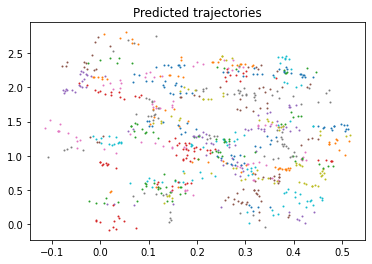

In [25]:
for (t,c) in pred_trajs:
    x = test_nodesdf_set.take(t)["centroid_x"].values
    y = test_nodesdf_set.take(t)["centroid_y"].values

    plt.scatter(x, y, s=1)
    plt.title("Predicted trajectories")

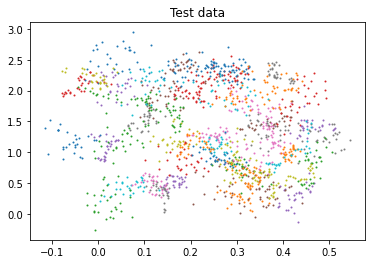

In [21]:
uniqueValues = test_nodesdf_set['label'].unique()
for u in uniqueValues:
    x = test_nodesdf_set[test_nodesdf_set['label'] == u]["centroid_x"].values
    y = test_nodesdf_set[test_nodesdf_set['label'] == u]["centroid_y"].values

    plt.scatter(x, y, s=1)
    plt.title("Test data")
    

## Function to calculate the accuracy

In [ ]:
def accuracy(pred_trajs, test_trajs):
    accuracy = 0
    count = 0
    for (t,c) in pred_trajs:
        label = test_trajs.iloc[t[0]]["label"]
        
        df = test_trajs[test_trajs['label'] == label].reset_index()
        for i in range(len(t)):
            count += 1
            if i == 0:
                if not df[df["index"]==t[0]].empty: # Checking whether t[0] is present in the df
                    if df[df["index"]==t[0]]["label"].values[0] == label: #Checking whether the label in df at index == t[i] is same as the value in the variable 'label'
                        accuracy += 1
                if df.iloc[0]["index"] == t[0]: #Checking whether the starting points in test and pred are same
                    accuracy += 1

            if i > 0:
                if not df[df["index"]==t[i]].empty: # Checking whether t[i] is present in the df
                    if df[df["index"]==t[i]]["label"].values[0] == label: # Checking whether the label in df at index == t[i] is same as the value in the variable 'label'
                        accuracy += 1
                if not df[df["index"]==t[i-1]].empty: # Checking whether t[i-1] is present in the df
                    prev_node_index = df[df["index"]==t[i-1]].index
                    if df.iloc[prev_node_index[0]]["index"] == t[i-1]: # Checking whether the previous node in df is same as the previous node in pred
                        accuracy += 1
    
    accuracy = (accuracy)/(2*count)*100
    return accuracy 


## Accuracy of the model in test_data

In [ ]:
tot_accuracy = 0
for set in uniqueValues_set:
    test_nodesdf_set = test_nodesdf[test_nodesdf["set"] ==  set]
    pred, gt, scores, graph = dt.models.gnns.get_predictions(
    test_nodesdf_set, ["intensity", "radius", "centroid"], model, variables
)
    edges_df, nodes, _ = dt.models.gnns.df_from_results(pred, gt, scores, graph)
    pred_trajs = dt.models.gnns.get_traj(edges_df, th = 8)
    tot_accuracy += accuracy(pred_trajs, test_nodesdf_set)

tot_accuracy /= 5

tot_accuracy


Creating graph edges...


100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Creating graph edges...


100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Creating graph edges...


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


Creating graph edges...


100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


Creating graph edges...


100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


95.14389032823952

## Testing with the experimental data

In [165]:
exp_data = pd.read_csv('df.csv') 
exp_data

,centroid_x,centroid_y,intensity,frame,set,label,solution
0,0.854289,0.045768,0.278431,0,0,0,0
1,0.873236,0.038116,0.231373,0,0,0,0
2,0.317296,0.034961,0.368627,0,0,0,0
3,0.777727,0.043664,0.184314,0,0,0,0
4,0.844072,0.046716,0.290196,0,0,0,0
...,...,...,...,...,...,...,...
5407,0.162054,0.966354,0.278431,9,0,0,0
5408,0.805682,0.966422,0.278431,9,0,0,0
5409,0.832681,0.969693,0.376471,9,0,0,0
5410,0.900964,0.971017,0.219608,9,0,0,0


In [166]:
exp_data.drop(exp_data[exp_data["frame"]>10].index, inplace = True)

In [167]:
exp_data

,centroid_x,centroid_y,intensity,frame,set,label,solution
0,0.854289,0.045768,0.278431,0,0,0,0
1,0.873236,0.038116,0.231373,0,0,0,0
2,0.317296,0.034961,0.368627,0,0,0,0
3,0.777727,0.043664,0.184314,0,0,0,0
4,0.844072,0.046716,0.290196,0,0,0,0
...,...,...,...,...,...,...,...
5407,0.162054,0.966354,0.278431,9,0,0,0
5408,0.805682,0.966422,0.278431,9,0,0,0
5409,0.832681,0.969693,0.376471,9,0,0,0
5410,0.900964,0.971017,0.219608,9,0,0,0


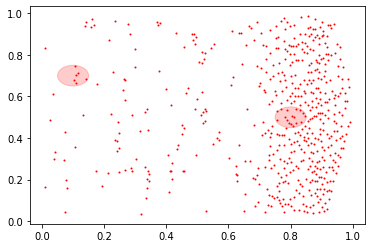

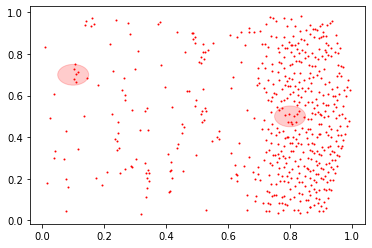

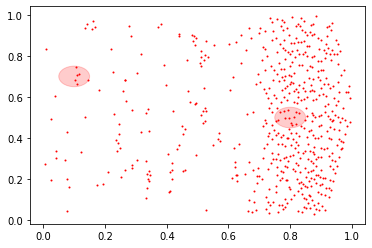

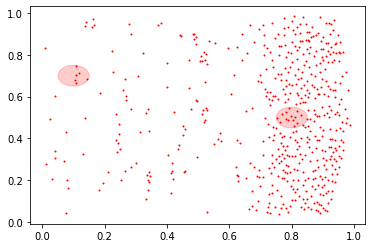

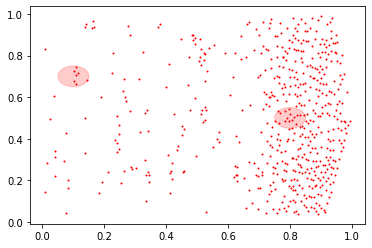

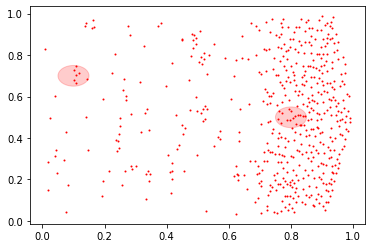

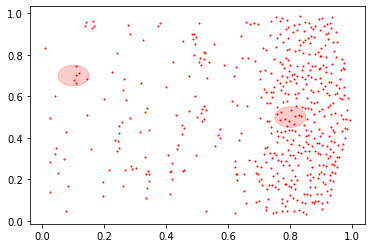

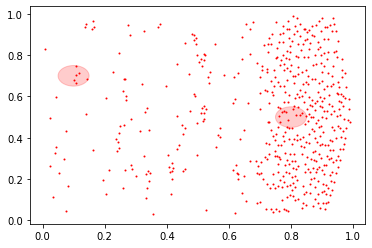

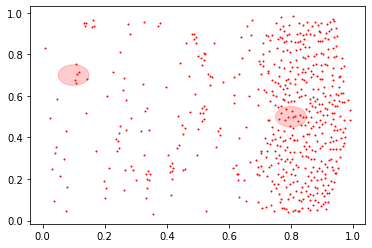

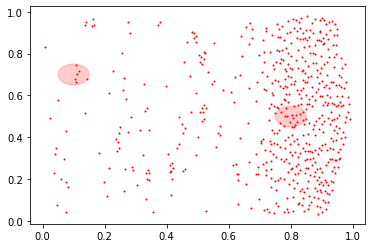

In [73]:


for i, frame in enumerate(os.listdir("./New sequence testing 2")):


    x = exp_data[exp_data["frame"]==i]["centroid_x"]
    y = exp_data[exp_data["frame"]==i]["centroid_y"]


    """img = plt.imread("./New sequence testing 2"+"/"+frame)
    plt.imshow(img,cmap = "gray")

    plt.scatter(x, y, s = 1, color = "red")"""

    fig, ax = plt.subplots()
    plt.scatter(x, y, s = 1, color = "red")
    circle1 = plt.Circle((.8, 0.5), 0.05, color='r', alpha = 0.2)
    circle2 = plt.Circle((.1, 0.7), 0.05, color='r', alpha = 0.2)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    plt.show()

In [175]:
pred, gt, scores, graph = dt.models.gnns.get_predictions(
    exp_data, ["centroid", "intensity"], model, variables
)  #

Creating graph edges...


100%|██████████| 1/1 [00:59<00:00, 59.38s/it]


In [176]:
edges_df, nodes, _ = dt.models.gnns.df_from_results(pred, gt, scores, graph)

In [177]:
pred_trajs = dt.models.gnns.get_traj(edges_df, th = 3)

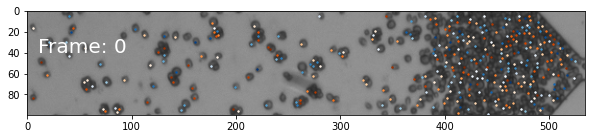

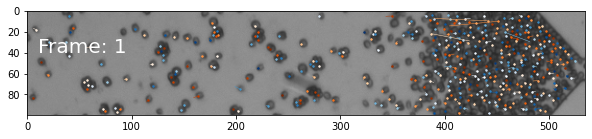

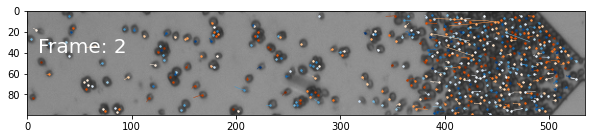

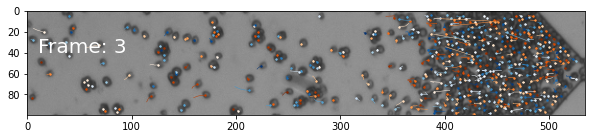

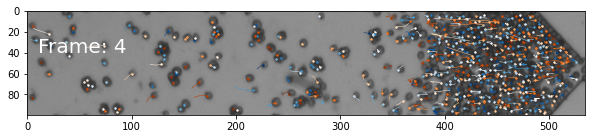

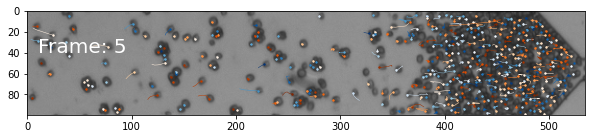

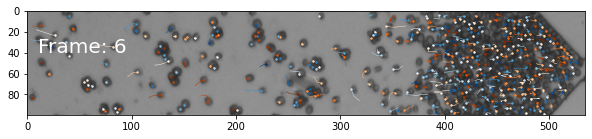

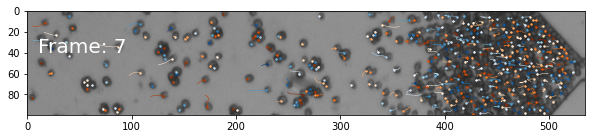

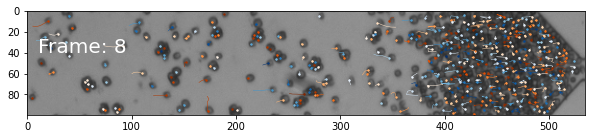

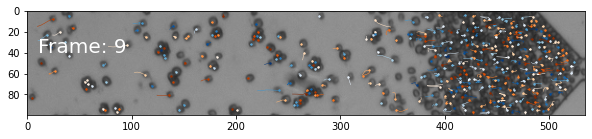

In [149]:

test_img_dir = "./New sequence testing 2"
count = 0

#colors = cm.rainbow(np.linspace(0, 1, len(pred_trajs)))
for i, frame in enumerate(os.listdir(test_img_dir)):
    if count > 10:
        break
    count += 1
    img = plt.imread(test_img_dir+"/"+frame)/255

    fig = plt.figure(figsize=(10, 50))
    plt.imshow(img, cmap= "gray", vmin = 0, vmax = 1)
    plt.text(10, 40, "Frame: " + str(i), fontsize=20, c="white")
    #plt.axis("off")
    

    for _, (t, c) in enumerate(pred_trajs):
        t = np.array(t)
        t = t[np.array(exp_data.take(t)["frame"].values <= i)]
        if len(t) != 0:
            if i < 5:
                t = t
                
                
            else:
                if exp_data.iloc[t[-1]]["frame"]== i:
                    t = t[-5:]
                else:
                    t = []
            
            

            
        
        x = exp_data.take(t)["centroid_x"].values*530
        y = exp_data.take(t)["centroid_y"].values*100

        if x.size != 0 and y.size !=0:
            plt.plot(x, y, linewidth=.5, color = c)
            plt.scatter(x[-1], y[-1], s=2, color = c)

    plt.savefig(f'./results/gnn1/{i}.png')

    
    plt.show()

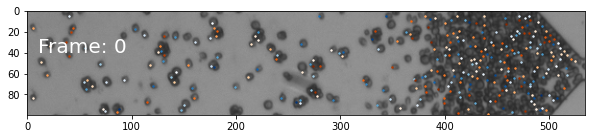

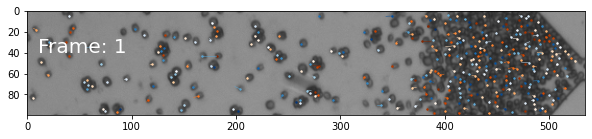

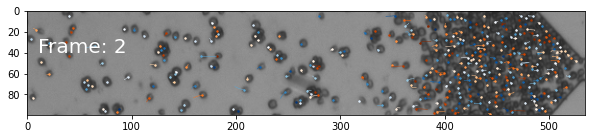

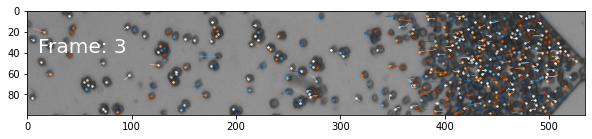

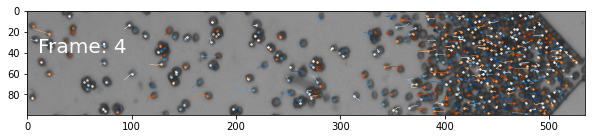

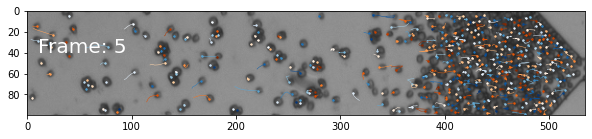

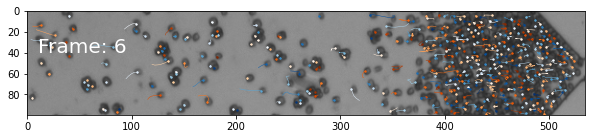

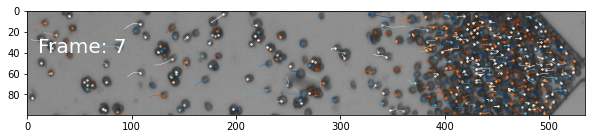

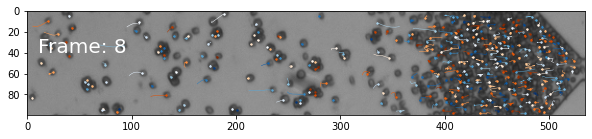

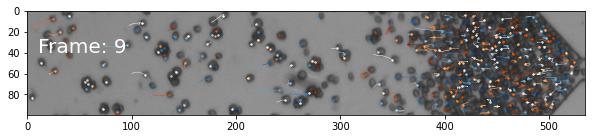

In [178]:
for f, frame in enumerate(os.listdir(test_img_dir)):

    img = plt.imread(test_img_dir+"/"+frame)/255

    fig = plt.figure(figsize=(10, 50))
    plt.imshow(img, cmap= "gray", vmin = 0, vmax = 1)
    plt.text(10, 40, "Frame: " + str(f), fontsize=20, c="white")

    for i, (t, c) in enumerate(pred_trajs):
        detections = nodes[t][(nodes[t, 0] <= f) & (nodes[t, 0] >= f - 5), :]

        if (len(detections) == 0) or (np.max(nodes[t, 0]) < f):
            continue

        plt.plot(detections[:, 1] * 530, detections[:, 2] * 100, color = c, linewidth=.5)
        plt.scatter(detections[-1, 1] * 530, detections[-1, 2] * 100, s = 2, c = c)

    plt.savefig(f'./results/gnn1/{i}.png')

In [47]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

import cv2
import os
image_folder = './results/gnn3'
video_name = 'trajectory_th-3_gnn3.avi'

images = sorted_alphanumeric(os.listdir(image_folder))
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()